In [4]:
# PACKAGES
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For plotting graphs
from sklearn.metrics import mean_squared_error, r2_score  # For model evaluation metrics
from sklearn.linear_model import LinearRegression  # For linear regression modeling
from sklearn.preprocessing import PolynomialFeatures  # For polynomial regression modeling
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing  # For time series forecasting
from tabulate import tabulate  # For tabular display of data
import os  # For interacting with the operating system
import json  # For handling JSON data

# DATA
file_path = 'data2.json'  # Path to the JSON data file
with open(file_path, 'r') as f:  # Open and read the JSON file
    json_data = json.load(f)  # Load data into a Python dictionary
data = pd.DataFrame(json_data)  # Convert dictionary to a pandas DataFrame
display(data)

,P/N,D-1,D-2,D-3,D-4,D-5,D-6,D-7,D-8,D-9,D-10,D-11,D-12,D-13
0,ZZ01,23,22,21,20,19,18,17,16,15,14,13,12,11
1,ZZ02,23,33,22,11,90,89,78,67,56,45,34,23,22
2,Z003,60,78,38,33,37,16,35,18,38,28,11,29,22
3,Z004,10,6,2,2,12,0,8,4,14,8,2,8,10
4,130083,4,18,6,6,10,24,6,16,12,18,0,6,6
5,131584,2,7,6,0,2,2,3,7,8,8,0,1,1
6,132770,2,0,0,0,2,0,0,2,0,0,0,0,0
7,205230,60,60,60,60,60,102,0,94,26,26,94,34,34
8,205401,0,120,96,1,98,2,0,66,1,49,144,0,0
9,3631163,0,128,64,64,64,128,64,128,64,128,0,64,64


In [5]:

# FUNCTION TO PROCESS DATA FOR A SPECIFIC P/N
def process_pn(data, pn_to_filter):
    # Filter data for the specified part number (P/N)
    filtered_data = data[data['P/N'] == pn_to_filter]
    formatted_data = []  # Initialize an empty list for formatted data
    # print(filtered_data)

    # Loop through filtered rows to reformat data
    for index, row in filtered_data.iterrows():
        # Extract quantities from D-2 to D-13 and reverse the order
        quantities = [row[f'D-{i}'] for i in range(2, 14)][::-1]  # Reverse here ## Kenapa 1 nya nggak di ambil?
        # print(quantities)

        # Create formatted data with period and quantity
        for period, quantity in enumerate(quantities, start=1):
            formatted_data.append({
                'P/N': str(row['P/N']),  # Ensure P/N is stored as a string
                'Period': period,  # Add period index
                'Quantity': quantity if not pd.isna(quantity) else None  # Handle missing data
            })

    # Convert the list of dictionaries to a DataFrame
    formatted_df = pd.DataFrame(formatted_data)
    # display(formatted_df)

    # Calculate mean and standard deviation, and set upper bound
    mean_quantity = formatted_df['Quantity'].mean()
    std_quantity = formatted_df['Quantity'].std()


    LB = 0  # Lower bound is set to 0
    UB = mean_quantity + 1.5 * std_quantity  # Calculate upper bound as mean + 1.5 * std deviation

    # round all data
    mean_quantity = round(mean_quantity, 4)  # Round mean value
    std_quantity = round(std_quantity, 4)  # Round standard deviation
    UB = round(UB, 4)  # Round upper bound

    # Print metrics in a table format
    table = [
        ["Mean Quantity", mean_quantity],
        ["Standard Deviation", std_quantity],
        ["Upper Bound (UB)", UB]
    ]
    print(tabulate(table, headers=["Metric", "Value"], tablefmt="pretty"))

    # Clip quantities to upper bound (replace values above UB with UB)
    formatted_df['Quantity'] = np.clip(formatted_df['Quantity'], LB, UB)
    return formatted_df  # Return the processed DataFrame

# SELECT P/N TO FILTER
pn_to_filter = "Z003"  # Change this to filter data for a different part number
formatted_df = process_pn(data, pn_to_filter)  # Process data for the selected P/N
display(formatted_df)

+--------------------+---------+
|       Metric       |  Value  |
+--------------------+---------+
|   Mean Quantity    | 31.9167 |
| Standard Deviation | 17.1648 |
|  Upper Bound (UB)  | 57.6638 |
+--------------------+---------+


,P/N,Period,Quantity
0,Z003,1,22.0000
1,Z003,2,29.0000
2,Z003,3,11.0000
3,Z003,4,28.0000
4,Z003,5,38.0000
5,Z003,6,18.0000
6,Z003,7,35.0000
7,Z003,8,16.0000
8,Z003,9,37.0000
9,Z003,10,33.0000


In [6]:

# MOVING AVERAGE
# Initialize Period column and moving average prediction column
formatted_df['Period'] = np.arange(1, len(formatted_df) + 1)
formatted_df['MA_Prediction'] = np.nan

# Calculate moving average for each period
for i in range(1, len(formatted_df) + 1):
    formatted_df.loc[formatted_df['Period'] == i, 'MA_Prediction'] = formatted_df['Quantity'].iloc[:i].mean()

display(formatted_df)

# If there are 12 periods, predict the 13th period as the mean of the last 12 quantities
if len(formatted_df) == 12:
    last_12_mean = formatted_df['Quantity'].iloc[-12:].mean()
    formatted_df = pd.concat([
        formatted_df,
        pd.DataFrame({'Period': [13], 'MA_Prediction': [last_12_mean], 'Quantity': [np.nan]})
    ], ignore_index=True)
    
display(formatted_df)
    

,P/N,Period,Quantity,MA_Prediction
0,Z003,1,22.0000,22.000000
1,Z003,2,29.0000,25.500000
2,Z003,3,11.0000,20.666667
3,Z003,4,28.0000,22.500000
4,Z003,5,38.0000,25.600000
5,Z003,6,18.0000,24.333333
6,Z003,7,35.0000,25.857143
7,Z003,8,16.0000,24.625000
8,Z003,9,37.0000,26.000000
9,Z003,10,33.0000,26.700000


,P/N,Period,Quantity,MA_Prediction
0,Z003,1,22.0000,22.000000
1,Z003,2,29.0000,25.500000
2,Z003,3,11.0000,20.666667
3,Z003,4,28.0000,22.500000
4,Z003,5,38.0000,25.600000
5,Z003,6,18.0000,24.333333
6,Z003,7,35.0000,25.857143
7,Z003,8,16.0000,24.625000
8,Z003,9,37.0000,26.000000
9,Z003,10,33.0000,26.700000


In [7]:

# WEIGHTED MOVING AVERAGE (WMA)
def calculate_exponential_weighted_moving_average(values, alpha_wma=0.3):
    # Calculate exponential weighted moving average with specified alpha
    return values.ewm(alpha=alpha_wma, adjust=False).mean()

alpha_wma = 0.3  # Smoothing parameter for WMA
formatted_df['Smoothed_Weighted_Prediction'] = calculate_exponential_weighted_moving_average(
    formatted_df['Quantity'], alpha_wma
)
display(formatted_df)

,P/N,Period,Quantity,MA_Prediction,Smoothed_Weighted_Prediction
0,Z003,1,22.0000,22.000000,22.000000
1,Z003,2,29.0000,25.500000,24.100000
2,Z003,3,11.0000,20.666667,20.170000
3,Z003,4,28.0000,22.500000,22.519000
4,Z003,5,38.0000,25.600000,27.163300
5,Z003,6,18.0000,24.333333,24.414310
6,Z003,7,35.0000,25.857143,27.590017
7,Z003,8,16.0000,24.625000,24.113012
8,Z003,9,37.0000,26.000000,27.979108
9,Z003,10,33.0000,26.700000,29.485376


In [8]:

# LINEAR REGRESSION
# Prepare data for linear regression
valid_data = formatted_df.dropna(subset=['Quantity'])
X = valid_data[['Period']]  # Independent variable
y = valid_data['Quantity']  # Dependent variable
print(X)
print(y)
model = LinearRegression()  # Initialize linear regression model
model.fit(X, y)  # Fit model to the data
formatted_df['Linear_Regression_Prediction'] = model.predict(formatted_df[['Period']])  # Predict for all periods
display(formatted_df)

    Period
0        1
1        2
2        3
3        4
4        5
5        6
6        7
7        8
8        9
9       10
10      11
11      12
0     22.0000
1     29.0000
2     11.0000
3     28.0000
4     38.0000
5     18.0000
6     35.0000
7     16.0000
8     37.0000
9     33.0000
10    38.0000
11    57.6638
Name: Quantity, dtype: float64


,P/N,Period,Quantity,MA_Prediction,Smoothed_Weighted_Prediction,Linear_Regression_Prediction
0,Z003,1,22.0000,22.000000,22.000000,18.235410
1,Z003,2,29.0000,25.500000,24.100000,20.414787
2,Z003,3,11.0000,20.666667,20.170000,22.594164
3,Z003,4,28.0000,22.500000,22.519000,24.773541
4,Z003,5,38.0000,25.600000,27.163300,26.952918
5,Z003,6,18.0000,24.333333,24.414310,29.132295
6,Z003,7,35.0000,25.857143,27.590017,31.311672
7,Z003,8,16.0000,24.625000,24.113012,33.491049
8,Z003,9,37.0000,26.000000,27.979108,35.670426
9,Z003,10,33.0000,26.700000,29.485376,37.849803


In [9]:

# POLYNOMIAL REGRESSION (DEGREE 2)
degree_2 = 2  # Degree of the polynomial
poly = PolynomialFeatures(degree=degree_2)  # Create polynomial features
X_poly = poly.fit_transform(X)  # Transform input features
poly_model = LinearRegression()  # Initialize linear regression model
poly_model.fit(X_poly, y)  # Fit polynomial model
X_all_poly = poly.transform(formatted_df[['Period']])  # Transform all periods
formatted_df['Polynomial_Regression_Prediction_Degree_2'] = poly_model.predict(X_all_poly)  # Predict values

# POLYNOMIAL REGRESSION (DEGREE 3)
degree_3 = 3  # Degree of the polynomial
poly = PolynomialFeatures(degree=degree_3)  # Create polynomial features
X_poly = poly.fit_transform(X)  # Transform input features
poly_model = LinearRegression()  # Initialize linear regression model
poly_model.fit(X_poly, y)  # Fit polynomial model
X_all_poly = poly.transform(formatted_df[['Period']])  # Transform all periods
formatted_df['Polynomial_Regression_Prediction_Degree_3'] = poly_model.predict(X_all_poly)  # Predict values

# SINGLE EXPONENTIAL SMOOTHING (SES)
alpha_ses = 0.8  # Smoothing parameter for SES
def apply_ses(values, alpha=alpha_ses):
    # Apply single exponential smoothing to the data
    ses_model = SimpleExpSmoothing(values).fit(smoothing_level=alpha, optimized=False)
    return ses_model.fittedvalues

# DOUBLE EXPONENTIAL SMOOTHING (DES)
beta_des = 0.3  # Trend smoothing parameter for DES
def apply_des(values, alpha=alpha_ses, beta=beta_des):
    # Apply double exponential smoothing to the data
    des_model = ExponentialSmoothing(values, trend='add', seasonal=None).fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)
    return des_model.fittedvalues

formatted_df['SES_Prediction'] = apply_ses(formatted_df['Quantity'], alpha=alpha_ses)  # Apply SES
formatted_df['DES_Prediction'] = apply_des(formatted_df['Quantity'], alpha=alpha_ses, beta=beta_des)  # Apply DES

display(formatted_df)

,P/N,Period,Quantity,MA_Prediction,Smoothed_Weighted_Prediction,Linear_Regression_Prediction,Polynomial_Regression_Prediction_Degree_2,Polynomial_Regression_Prediction_Degree_3,SES_Prediction,DES_Prediction
0,Z003,1,22.0000,22.000000,22.000000,18.235410,25.444701,20.560692,22.000000,21.763636
1,Z003,2,29.0000,25.500000,24.100000,20.414787,23.691737,24.135738,22.000000,23.106424
2,Z003,3,11.0000,20.666667,20.170000,22.594164,22.725242,25.833248,27.600000,30.389440
3,Z003,4,28.0000,22.500000,22.519000,24.773541,22.545215,26.245222,14.320000,12.792578
4,Z003,5,38.0000,25.600000,27.163300,26.952918,23.151656,25.963661,25.264000,26.522986
5,Z003,6,18.0000,24.333333,24.414310,29.132295,24.544565,25.580567,35.452800,40.023551
6,Z003,7,35.0000,25.857143,27.590017,31.311672,26.723942,25.687940,21.490560,21.438012
7,Z003,8,16.0000,24.625000,24.113012,33.491049,29.689787,26.877781,32.298112,34.575781
8,Z003,9,37.0000,26.000000,27.979108,35.670426,33.442100,29.742093,19.259622,17.545148
9,Z003,10,33.0000,26.700000,29.485376,37.849803,37.980881,34.872875,33.451924,35.608185


In [10]:

# RMSE & R2 METRICS
results = []  # Initialize list to store results
# Evaluate models for RMSE and R2
for column in ['MA_Prediction', 'Smoothed_Weighted_Prediction', 'Linear_Regression_Prediction',
               'Polynomial_Regression_Prediction_Degree_2', 'Polynomial_Regression_Prediction_Degree_3',
               'SES_Prediction', 'DES_Prediction']:
    valid_data = formatted_df.dropna(subset=['Quantity', column])  # Filter valid data
    if valid_data.empty:  # Skip if no valid data
        print(f"Skipping {column} due to lack of valid data.")
        continue
    try:
        rmse = np.sqrt(mean_squared_error(valid_data['Quantity'], valid_data[column]))  # Calculate RMSE
        r2 = r2_score(valid_data['Quantity'], valid_data[column])  # Calculate R2
        results.append({'Model': column, 'RMSE': rmse, 'R2': r2})  # Append results
    except Exception as e:
        print(f"Error evaluating {column}: {e}")  # Handle errors

results_df = pd.DataFrame(results)  # Convert results to a DataFrame
display(valid_data)
display(results_df)

,P/N,Period,Quantity,MA_Prediction,Smoothed_Weighted_Prediction,Linear_Regression_Prediction,Polynomial_Regression_Prediction_Degree_2,Polynomial_Regression_Prediction_Degree_3,SES_Prediction,DES_Prediction
0,Z003,1,22.0000,22.000000,22.000000,18.235410,25.444701,20.560692,22.000000,21.763636
1,Z003,2,29.0000,25.500000,24.100000,20.414787,23.691737,24.135738,22.000000,23.106424
2,Z003,3,11.0000,20.666667,20.170000,22.594164,22.725242,25.833248,27.600000,30.389440
3,Z003,4,28.0000,22.500000,22.519000,24.773541,22.545215,26.245222,14.320000,12.792578
4,Z003,5,38.0000,25.600000,27.163300,26.952918,23.151656,25.963661,25.264000,26.522986
5,Z003,6,18.0000,24.333333,24.414310,29.132295,24.544565,25.580567,35.452800,40.023551
6,Z003,7,35.0000,25.857143,27.590017,31.311672,26.723942,25.687940,21.490560,21.438012
7,Z003,8,16.0000,24.625000,24.113012,33.491049,29.689787,26.877781,32.298112,34.575781
8,Z003,9,37.0000,26.000000,27.979108,35.670426,33.442100,29.742093,19.259622,17.545148
9,Z003,10,33.0000,26.700000,29.485376,37.849803,37.980881,34.872875,33.451924,35.608185


,Model,RMSE,R2
0,MA_Prediction,11.206658,0.136693
1,Smoothed_Weighted_Prediction,8.507006,0.502531
2,Linear_Regression_Prediction,9.427308,0.389074
3,Polynomial_Regression_Prediction_Degree_2,8.466140,0.507299
4,Polynomial_Regression_Prediction_Degree_3,7.891684,0.571893
5,SES_Prediction,13.515168,-0.255613
6,DES_Prediction,14.412499,-0.427880


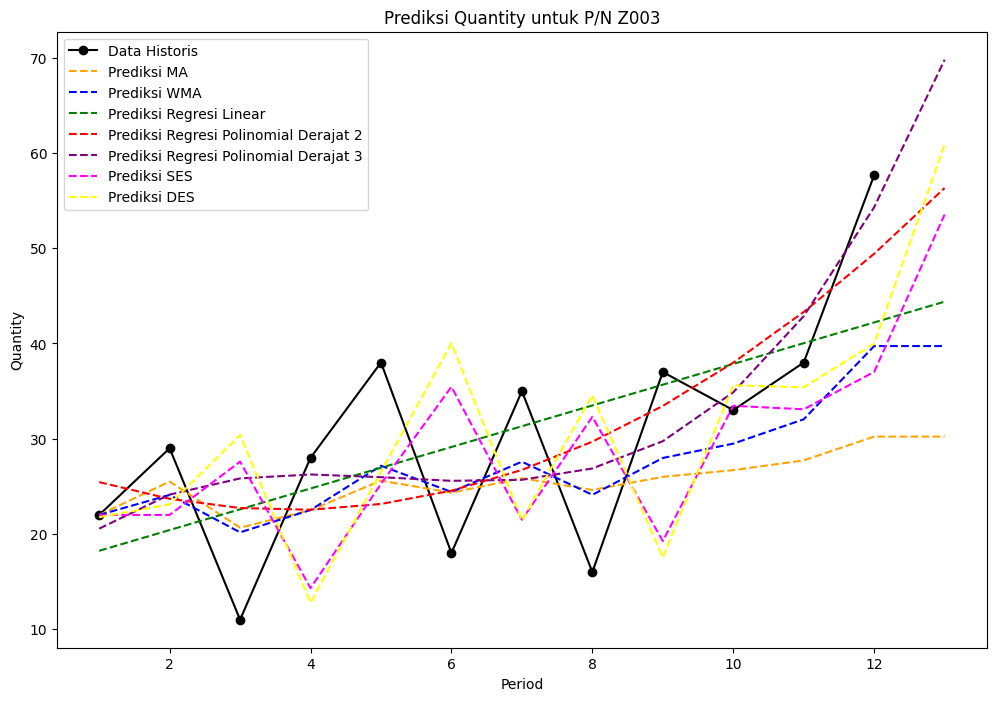

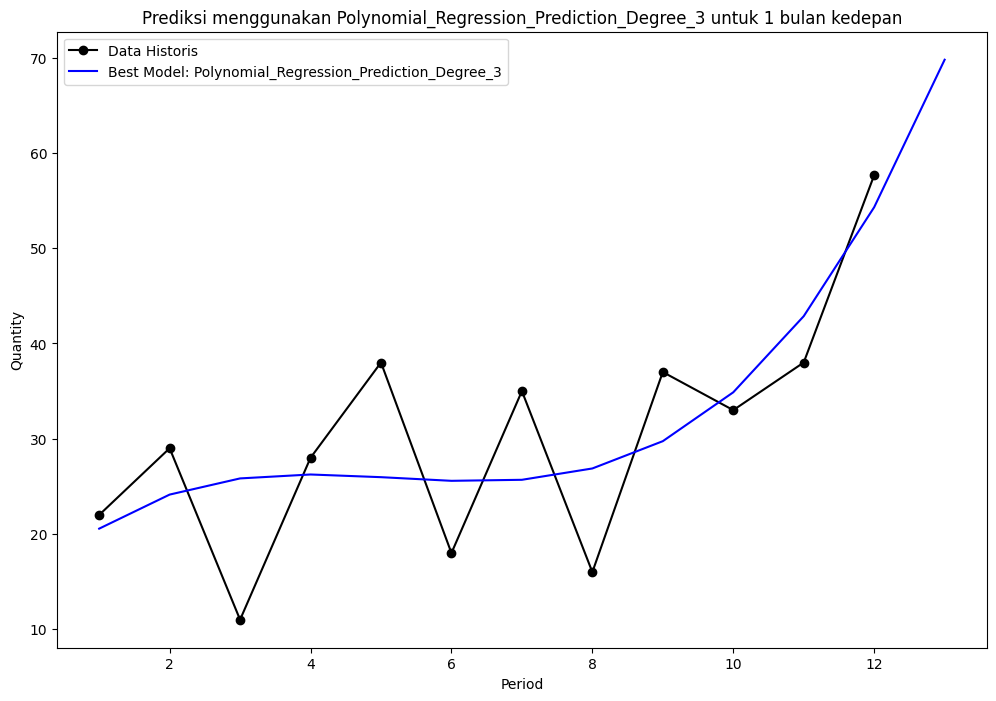

╒════╤═══════╤══════════╤════════════╤═════════════════╤════════════════════════════════╤════════════════════════════════╤═════════════════════════════════════════════╤═════════════════════════════════════════════╤══════════════════╤══════════════════╕
│    │ P/N   │   Period │   Quantity │   MA_Prediction │   Smoothed_Weighted_Prediction │   Linear_Regression_Prediction │   Polynomial_Regression_Prediction_Degree_2 │   Polynomial_Regression_Prediction_Degree_3 │   SES_Prediction │   DES_Prediction │
╞════╪═══════╪══════════╪════════════╪═════════════════╪════════════════════════════════╪════════════════════════════════╪═════════════════════════════════════════════╪═════════════════════════════════════════════╪══════════════════╪══════════════════╡
│  0 │ Z003  │        1 │    22      │         22      │                        22      │                        18.2354 │                                     25.4447 │                                     20.5607 │          22      │        

,P/N,Period,Quantity,MA_Prediction,Smoothed_Weighted_Prediction,Linear_Regression_Prediction,Polynomial_Regression_Prediction_Degree_2,Polynomial_Regression_Prediction_Degree_3,SES_Prediction,DES_Prediction
0,Z003,1,22.0000,22.000000,22.000000,18.235410,25.444701,20.560692,22.000000,21.763636
1,Z003,2,29.0000,25.500000,24.100000,20.414787,23.691737,24.135738,22.000000,23.106424
2,Z003,3,11.0000,20.666667,20.170000,22.594164,22.725242,25.833248,27.600000,30.389440
3,Z003,4,28.0000,22.500000,22.519000,24.773541,22.545215,26.245222,14.320000,12.792578
4,Z003,5,38.0000,25.600000,27.163300,26.952918,23.151656,25.963661,25.264000,26.522986
5,Z003,6,18.0000,24.333333,24.414310,29.132295,24.544565,25.580567,35.452800,40.023551
6,Z003,7,35.0000,25.857143,27.590017,31.311672,26.723942,25.687940,21.490560,21.438012
7,Z003,8,16.0000,24.625000,24.113012,33.491049,29.689787,26.877781,32.298112,34.575781
8,Z003,9,37.0000,26.000000,27.979108,35.670426,33.442100,29.742093,19.259622,17.545148
9,Z003,10,33.0000,26.700000,29.485376,37.849803,37.980881,34.872875,33.451924,35.608185


In [11]:

# BEST MODEL SELECTION
best_model_row = results_df.loc[results_df['R2'].idxmax()]  # Select best model by highest R2
best_model_name = best_model_row['Model']  # Best model name
best_model_r2 = best_model_row['R2']  # Best model R2 value
next_period_prediction = formatted_df.loc[formatted_df['Period'] == 13, best_model_name].values[0]  # Predict next period

# PLOT ALL GRAPHS
plt.figure(figsize=(12, 8))  # Set figure size
plt.plot(formatted_df['Period'], formatted_df['Quantity'], label='Data Historis', marker='o', color='black')  # Plot historical data
plt.plot(formatted_df['Period'], formatted_df['MA_Prediction'], label='Prediksi MA', linestyle='--', color='orange')  # Plot MA predictions
plt.plot(formatted_df['Period'], formatted_df['Smoothed_Weighted_Prediction'], label='Prediksi WMA', linestyle='--', color='blue')  # Plot WMA predictions
plt.plot(formatted_df['Period'], formatted_df['Linear_Regression_Prediction'], label='Prediksi Regresi Linear', linestyle='--', color='green')  # Plot linear regression predictions
plt.plot(formatted_df['Period'], formatted_df['Polynomial_Regression_Prediction_Degree_2'], label='Prediksi Regresi Polinomial Derajat 2', linestyle='--', color='red')  # Plot polynomial regression (degree 2) predictions
plt.plot(formatted_df['Period'], formatted_df['Polynomial_Regression_Prediction_Degree_3'], label='Prediksi Regresi Polinomial Derajat 3', linestyle='--', color='purple')  # Plot polynomial regression (degree 3) predictions
plt.plot(formatted_df['Period'], formatted_df['SES_Prediction'], label='Prediksi SES', linestyle='--', color='magenta')  # Plot SES predictions
plt.plot(formatted_df['Period'], formatted_df['DES_Prediction'], label='Prediksi DES', linestyle='--', color='yellow')  # Plot DES predictions
plt.xlabel('Period')  # Set x-axis label
plt.ylabel('Quantity')  # Set y-axis label
plt.title(f'Prediksi Quantity untuk P/N {pn_to_filter}')  # Set plot title
plt.legend()  # Add legend
plt.grid(False)  # Disable grid
plt.show()  # Display the plot

# PLOT BEST MODEL
plt.figure(figsize=(12, 8))  # Set figure size
plt.plot(formatted_df['Period'], formatted_df['Quantity'], label='Data Historis', marker='o', color='black')  # Plot historical data
plt.plot(formatted_df['Period'], formatted_df[best_model_name], label=f'Best Model: {best_model_name}', linestyle='-', color='blue')  # Plot best model predictions
plt.xlabel('Period')  # Set x-axis label
plt.ylabel('Quantity')  # Set y-axis label
plt.title(f'Prediksi menggunakan {best_model_name} untuk 1 bulan kedepan')  # Set plot title
plt.legend()  # Add legend
plt.grid(False)  # Disable grid
plt.show()  # Display the plot

# DISPLAY DATAFRAMES
print(tabulate(formatted_df, headers='keys', tablefmt='fancy_grid'))  # Print formatted data
print(tabulate(results_df.sort_values(by='R2', ascending=False), headers='keys', tablefmt='fancy_grid'))  # Print sorted results

# DISPLAY BEST MODEL SUMMARY
table_data = [
    ["P/N", pn_to_filter],
    ["Best Model", best_model_name],
    ["Best R-squared", f"{best_model_r2:.4f}"],
    ["Prediction for 13th Period", f"{next_period_prediction:.0f}"]
]
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt="fancy_grid"))  # Print summary
display(formatted_df)
# EXPORT RESULTS TO JSON
output_file_path = 'results.json'  # Path to output file
formatted_df.to_json(output_file_path, orient='records', indent=4)  # Save DataFrame to JSON
